In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_class_0 = '/content/drive/My Drive/ctg_2_classes/class_0'
path_class_1 = '/content/drive/My Drive/ctg_2_classes/class_1'

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

### Dataset preparation

4 datasets created: training, validation and two for testing: class 0 and class 1 (half of 0)

In [ ]:
class DataLoader:
    def __init__(self, path_class_0, path_class_1, sequence_length=10, batch_size=128):
        self.path_class_0 = path_class_0
        self.path_class_1 = path_class_1
        self.sequence_length = sequence_length
        self.batch_size = batch_size

    def load_data(self, directory):
        all_files = os.listdir(directory)
        sequences = []
        for filename in all_files:
            file_path = os.path.join(directory, filename)
            data = pd.read_csv(file_path, usecols=['Filtered_FHR'])
            seq = data['Filtered_FHR'].values
            if len(seq) > self.sequence_length:
                sequences.append(seq)
            else:
                print(f"{filename} was removed")
        return sequences

    def normalize_data(self, data):
        all_data = np.vstack([seq.reshape(-1, 1) for seq in data])
        scaler = StandardScaler()
        scaler.fit(all_data)
        normalized_data = [scaler.transform(seq.reshape(-1, 1)).flatten() for seq in data]
        return normalized_data, scaler

    def load_and_preprocess_data(self):
        data_class_0 = self.load_data(self.path_class_0)
        data_class_1 = self.load_data(self.path_class_1)

        np.random.seed(42)
        indices = np.random.choice(len(data_class_1), size=len(data_class_0)//2, replace=False)
        test_1 = [data_class_1[i] for i in indices]
        train = [data for i, data in enumerate(data_class_1) if i not in indices]

        train_norm, scaler = self.normalize_data(train)
        test_1_norm = [scaler.transform(seq.reshape(-1, 1)).flatten() for seq in test_1]
        test_0_norm = [scaler.transform(seq.reshape(-1, 1)).flatten() for seq in data_class_0]

        return train_norm, test_1_norm, test_0_norm, scaler

    def split_train_val(self, data):
        len_train = len(data)
        len_val = round(len_train * 0.2)

        np.random.seed(42)
        indices = np.random.choice(len_train, size=len_val, replace=False)
        val_data = [data[i] for i in indices]
        train_data = [d for i, d in enumerate(data) if i not in indices]

        return train_data, val_data

    def create_dataset(self, data):
        seq_len = self.sequence_length
        all_dataset = None
        for record in data:
            inputs = record[:-1]
            targets = record[seq_len:]
            dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
                inputs, targets, sequence_length=seq_len, shuffle=True, batch_size=self.batch_size
            )
            if all_dataset is None:
                all_dataset = dataset
            else:
                all_dataset = all_dataset.concatenate(dataset)
        return all_dataset

    def prepare_datasets(self):
        train_norm, test_1_norm, test_0_norm, _ = self.load_and_preprocess_data()
        train_data, val_data = self.split_train_val(train_norm)

        train_ds = self.create_dataset(train_data)
        val_ds = self.create_dataset(val_data)
        test_1_ds = self.create_dataset(test_1_norm)
        test_0_ds = self.create_dataset(test_0_norm)

        return train_ds, val_ds, test_1_ds, test_0_ds



In [ ]:
data_loader = DataLoader(path_class_0, path_class_1)

train_ds, val_ds, test_1_ds, test_0_ds = data_loader.prepare_datasets()

1093.csv was removed


In [ ]:
def plot_history(history):
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper right')


  plt.tight_layout()
  plt.show()

In [ ]:
def plot_history_part(history, epochs):
    train_loss = history.history['loss'][:epochs]
    val_loss = history.history['val_loss'][:epochs]

    epochs_range = range(1, len(train_loss) + 1)

    plt.plot(epochs_range, train_loss, label='Training loss')
    plt.plot(epochs_range, val_loss, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

### Base Model
Predict next value as the last in one in sequence input

In [ ]:
class MovingAverage(tf.keras.Model):
    def __init__(self, sequence_size):
        super(MovingAverage, self).__init__()
        self.window_size = sequence_size
        self.avg_layer = tf.keras.layers.AveragePooling1D(pool_size=sequence_size, padding='same')

    def call(self, inputs):
        inputs = tf.expand_dims(inputs, axis=-1)
        smoothed = self.avg_layer(inputs)
        smoothed = tf.squeeze(smoothed, axis=-1)
        return smoothed

In [ ]:
device_name = tf.test.gpu_device_name()

In [ ]:
with tf.device(device_name):
    baseline = MovingAverage(10)
    baseline.compile(loss=tf.losses.MeanAbsoluteError(),
                 metrics=[tf.metrics.MeanSquaredError()])

In [ ]:
test_0_base = baseline.evaluate(test_0_ds)

3418/3418 [==============================] - 18s 5ms/step - loss: 0.1399 - mean_squared_error: 0.0748


In [ ]:
test_1_base = baseline.evaluate(test_1_ds)

1790/1790 [==============================] - 9s 5ms/step - loss: 0.1212 - mean_squared_error: 0.0575


### TCNN, seq = 10

In [ ]:
sequence_length = 10

In [ ]:
def residual_block(inputs):
    shortcut = inputs
    x = layers.Conv1D(filters=32, kernel_size=3, dilation_rate=1, activation='relu', padding='causal')(inputs)
    x = layers.Conv1D(filters=32, kernel_size=3, dilation_rate=2, activation='relu', padding='causal')(x)
    x = layers.Conv1D(filters=32, kernel_size=3, dilation_rate=4, activation='relu', padding='causal')(x)

    if x.shape[-1] != shortcut.shape[-1]:
        shortcut = layers.Conv1D(filters=32, kernel_size=1, padding='same')(shortcut)


    x = layers.add([x, shortcut])

    return x

In [ ]:
def residual_block2(inputs):
    shortcut = inputs
    x = layers.Conv1D(filters=32, kernel_size=3, dilation_rate=1, activation='relu', padding='causal')(inputs)
    x = layers.Conv1D(filters=32, kernel_size=3, dilation_rate=2, activation='relu', padding='causal')(x)
    x = layers.Conv1D(filters=32, kernel_size=3, dilation_rate=4, activation='relu', padding='causal')(x)
    x = layers.Conv1D(filters=32, kernel_size=3, dilation_rate=8, activation='relu', padding='causal')(x)

    if x.shape[-1] != shortcut.shape[-1]:
        shortcut = layers.Conv1D(filters=32, kernel_size=1, padding='same')(shortcut)


    x = layers.add([x, shortcut])

    return x

In [ ]:
inputs = layers.Input(shape=(sequence_length, 1))
x = residual_block(inputs)
x = residual_block2(x)

query = layers.Dense(units=32)(x)
value = layers.Dense(units=32)(x)
attention = layers.Attention()([query, value])

x = layers.Flatten()(attention)

x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(1)(x)

tcnn_10 = keras.models.Model(inputs=inputs, outputs=output)

In [ ]:
tcnn_10.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_squared_error'])

In [ ]:
tcnn_10.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 10, 1)]              0         []                            
                                                                                                  
 conv1d_1 (Conv1D)           (None, 10, 32)               128       ['input_2[0][0]']             
                                                                                                  
 conv1d_2 (Conv1D)           (None, 10, 32)               3104      ['conv1d_1[0][0]']            
                                                                                                  
 conv1d_3 (Conv1D)           (None, 10, 32)               3104      ['conv1d_2[0][0]']            
                                                                                            

In [ ]:
model_checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/My Drive/tcnn10.keras',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

history_tcnn10 = tcnn_10.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        model_checkpoint_callback,
        reduce_lr
    ]
)


Epoch 1/50
14401/14405 [============================>.] - ETA: 0s - loss: 0.0333 - mean_squared_error: 0.0067
Epoch 1: val_loss improved from inf to 0.02585, saving model to /content/drive/My Drive/tcnn10.keras
14405/14405 [==============================] - 179s 12ms/step - loss: 0.0333 - mean_squared_error: 0.0067 - val_loss: 0.0258 - val_mean_squared_error: 0.0046 - lr: 0.0010
Epoch 2/50
14401/14405 [============================>.] - ETA: 0s - loss: 0.0271 - mean_squared_error: 0.0053
Epoch 2: val_loss improved from 0.02585 to 0.02441, saving model to /content/drive/My Drive/tcnn10.keras
14405/14405 [==============================] - 139s 10ms/step - loss: 0.0271 - mean_squared_error: 0.0053 - val_loss: 0.0244 - val_mean_squared_error: 0.0047 - lr: 0.0010
Epoch 3/50
14399/14405 [============================>.] - ETA: 0s - loss: 0.0261 - mean_squared_error: 0.0052
Epoch 3: val_loss improved from 0.02441 to 0.02251, saving model to /content/drive/My Drive/tcnn10.keras
14405/14405 [====

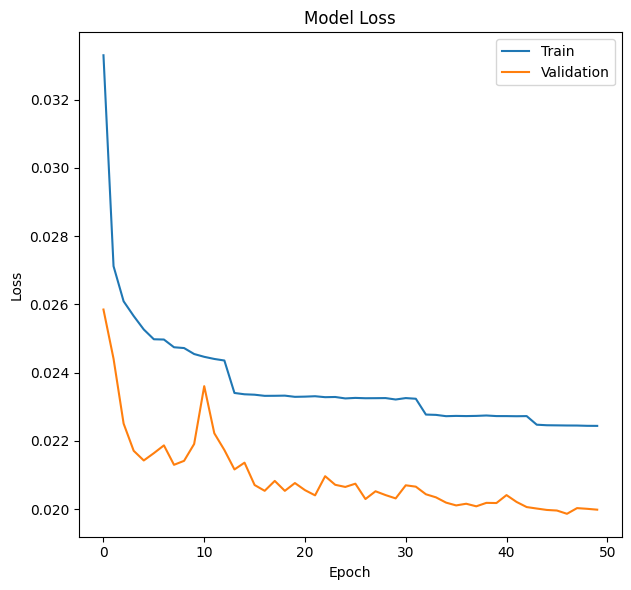

In [ ]:
plot_history(history_tcnn10)

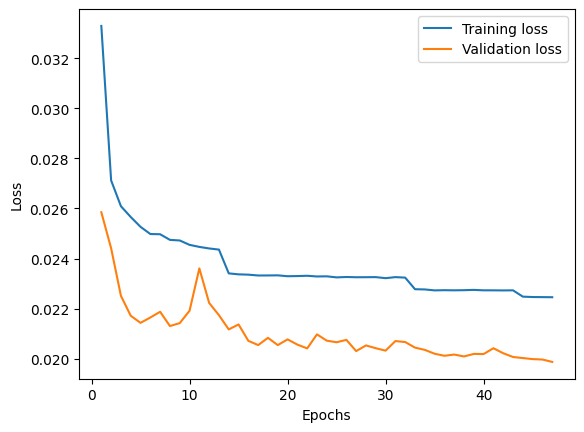

In [ ]:
plot_history_part(history_tcnn10, 47)

### CNN, seq 10, kernel 32

In [ ]:
sequence_length = 10

In [ ]:
inputs = keras.Input(shape = (sequence_length, 1))
x = layers.Conv1D(filters = 32, kernel_size = 10, activation = 'relu', padding = 'same')(inputs)
x = layers.MaxPool1D(pool_size = 2)(x)

x = layers.Conv1D(filters = 32, kernel_size = 5, activation = 'relu', padding = 'same')(x)
x = layers.MaxPool1D(pool_size = 2)(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1)(x)


cnn_10 = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
cnn_10.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_squared_error'])

In [ ]:
model_checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/My Drive/cnn10.keras',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

history_cnn10 = cnn_10.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        model_checkpoint_callback,
        reduce_lr
    ]
)

Epoch 1/50
14393/14405 [============================>.] - ETA: 0s - loss: 0.0330 - mean_squared_error: 0.0069
Epoch 1: val_loss improved from inf to 0.02762, saving model to /content/drive/My Drive/cnn10.keras
14405/14405 [==============================] - 117s 8ms/step - loss: 0.0330 - mean_squared_error: 0.0069 - val_loss: 0.0276 - val_mean_squared_error: 0.0047 - lr: 0.0010
Epoch 2/50
14401/14405 [============================>.] - ETA: 0s - loss: 0.0289 - mean_squared_error: 0.0054
Epoch 2: val_loss improved from 0.02762 to 0.02450, saving model to /content/drive/My Drive/cnn10.keras
14405/14405 [==============================] - 106s 7ms/step - loss: 0.0289 - mean_squared_error: 0.0054 - val_loss: 0.0245 - val_mean_squared_error: 0.0046 - lr: 0.0010
Epoch 3/50
14402/14405 [============================>.] - ETA: 0s - loss: 0.0276 - mean_squared_error: 0.0053
Epoch 3: val_loss improved from 0.02450 to 0.02446, saving model to /content/drive/My Drive/cnn10.keras
14405/14405 [=========

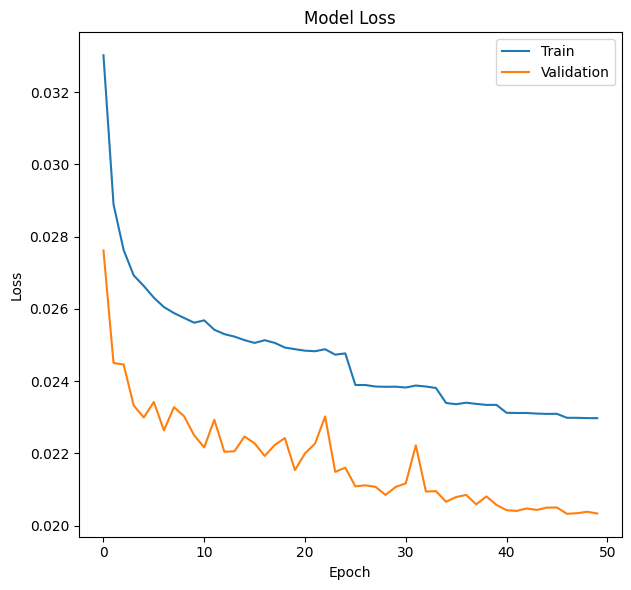

In [ ]:
plot_history(history_cnn10)

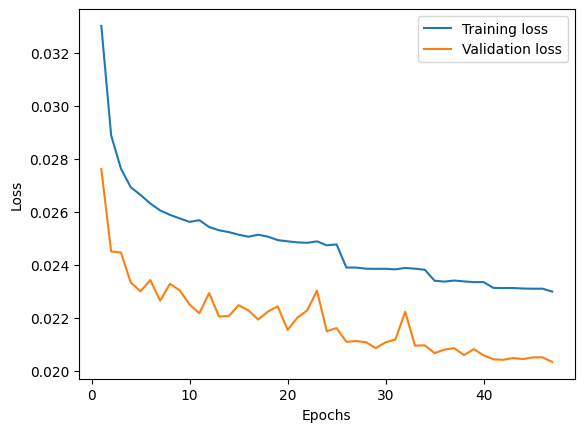

In [ ]:
plot_history_part(history_cnn10, 47)

### CNN, seq 20, kernel 32

In [ ]:
sequence_length = 20

In [ ]:
data_loader = DataLoader(path_class_0, path_class_1, sequence_length = 20)

train_ds, val_ds, test_1_ds, test_0_ds = data_loader.prepare_datasets()

1093.csv was removed


In [ ]:
inputs = keras.Input(shape = (sequence_length, 1))
x = layers.Conv1D(filters = 32, kernel_size = 10, activation = 'relu', padding = 'same')(inputs)
x = layers.MaxPool1D(pool_size = 2)(x)

x = layers.Conv1D(filters = 32, kernel_size = 5, activation = 'relu', padding = 'same')(x)
x = layers.MaxPool1D(pool_size = 2)(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1)(x)


cnn_20 = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
cnn_20.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_squared_error'])

In [ ]:
model_checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/My Drive/cnn20.keras',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

history_cnn20 = cnn_20.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        model_checkpoint_callback,
        reduce_lr
    ]
)

Epoch 1/50
14380/14381 [============================>.] - ETA: 0s - loss: 0.0329 - mean_squared_error: 0.0069
Epoch 1: val_loss improved from inf to 0.02636, saving model to /content/drive/My Drive/cnn20.keras
14381/14381 [==============================] - 129s 9ms/step - loss: 0.0329 - mean_squared_error: 0.0069 - val_loss: 0.0264 - val_mean_squared_error: 0.0048 - lr: 0.0010
Epoch 2/50
14380/14381 [============================>.] - ETA: 0s - loss: 0.0286 - mean_squared_error: 0.0053
Epoch 2: val_loss did not improve from 0.02636
14381/14381 [==============================] - 118s 8ms/step - loss: 0.0286 - mean_squared_error: 0.0053 - val_loss: 0.0288 - val_mean_squared_error: 0.0049 - lr: 0.0010
Epoch 3/50
14378/14381 [============================>.] - ETA: 0s - loss: 0.0273 - mean_squared_error: 0.0052
Epoch 3: val_loss improved from 0.02636 to 0.02418, saving model to /content/drive/My Drive/cnn20.keras
14381/14381 [==============================] - 119s 8ms/step - loss: 0.0273 - m

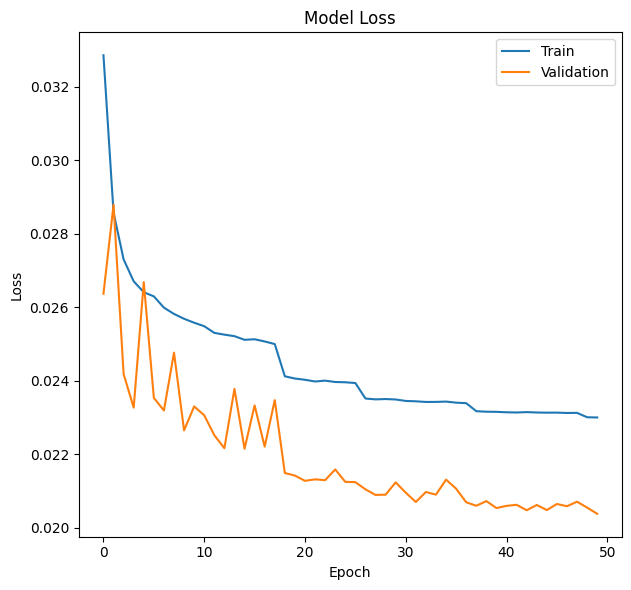

In [ ]:
plot_history(history_cnn20)

### TCNN, seq = 20

In [ ]:
sequence_length = 20

In [ ]:
inputs = layers.Input(shape=(sequence_length, 1))
x = residual_block(inputs)
x = residual_block2(x)

query = layers.Dense(units=32)(x)
value = layers.Dense(units=32)(x)
attention = layers.Attention()([query, value])

x = layers.Flatten()(attention)

x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(1)(x)

tcnn_20 = keras.models.Model(inputs=inputs, outputs=output)

In [ ]:
tcnn_20.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 20, 1)]              0         []                            
                                                                                                  
 conv1d_14 (Conv1D)          (None, 20, 32)               128       ['input_5[0][0]']             
                                                                                                  
 conv1d_15 (Conv1D)          (None, 20, 32)               3104      ['conv1d_14[0][0]']           
                                                                                                  
 conv1d_16 (Conv1D)          (None, 20, 32)               3104      ['conv1d_15[0][0]']           
                                                                                            

In [ ]:
tcnn_20.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_squared_error'])

In [ ]:
model_checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/My Drive/tcnn20.keras',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

history_tcnn20 = tcnn_20.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        model_checkpoint_callback,
        reduce_lr
    ]
)

Epoch 1/50
14374/14381 [============================>.] - ETA: 0s - loss: 0.0345 - mean_squared_error: 0.0069
Epoch 1: val_loss improved from inf to 0.02404, saving model to /content/drive/My Drive/tcnn20.keras
14381/14381 [==============================] - 181s 12ms/step - loss: 0.0345 - mean_squared_error: 0.0069 - val_loss: 0.0240 - val_mean_squared_error: 0.0047 - lr: 0.0010
Epoch 2/50
14376/14381 [============================>.] - ETA: 0s - loss: 0.0277 - mean_squared_error: 0.0053
Epoch 2: val_loss improved from 0.02404 to 0.02304, saving model to /content/drive/My Drive/tcnn20.keras
14381/14381 [==============================] - 140s 10ms/step - loss: 0.0277 - mean_squared_error: 0.0053 - val_loss: 0.0230 - val_mean_squared_error: 0.0045 - lr: 0.0010
Epoch 3/50
14381/14381 [==============================] - ETA: 0s - loss: 0.0263 - mean_squared_error: 0.0052
Epoch 3: val_loss improved from 0.02304 to 0.02251, saving model to /content/drive/My Drive/tcnn20.keras
14381/14381 [====

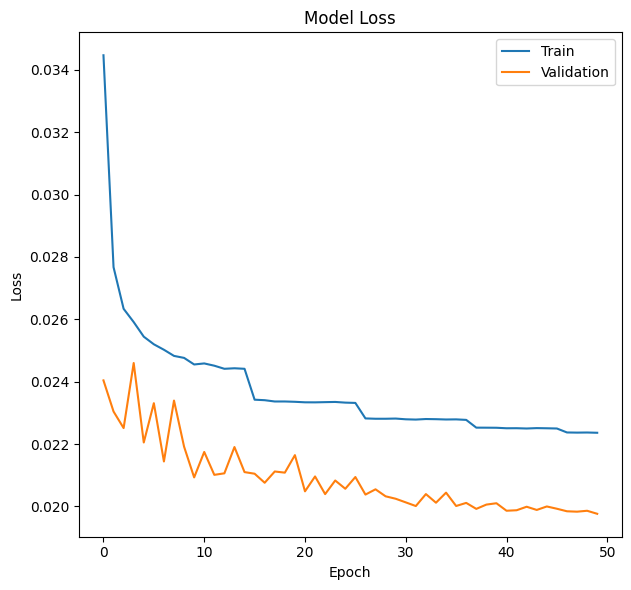

In [ ]:
plot_history(history_tcnn20 )

## CNN, seq = 30

In [ ]:
sequence_length = 30

In [ ]:
data_loader = DataLoader(path_class_0, path_class_1, sequence_length = 30)

train_ds, val_ds, test_1_ds, test_0_ds = data_loader.prepare_datasets()

1093.csv was removed


In [ ]:
inputs = keras.Input(shape = (sequence_length, 1))
x = layers.Conv1D(filters = 32, kernel_size = 10, activation = 'relu', padding = 'same')(inputs)
x = layers.MaxPool1D(pool_size = 2)(x)

x = layers.Conv1D(filters = 32, kernel_size = 5, activation = 'relu', padding = 'same')(x)
x = layers.MaxPool1D(pool_size = 2)(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1)(x)


cnn_30 = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
cnn_30.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_squared_error'])

In [ ]:
model_checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/My Drive/cnn30.keras',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

history_cnn30 = cnn_30.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        model_checkpoint_callback,
        reduce_lr
    ]
)

Epoch 1/50
14348/14359 [============================>.] - ETA: 0s - loss: 0.0347 - mean_squared_error: 0.0076
Epoch 1: val_loss improved from inf to 0.02587, saving model to /content/drive/My Drive/cnn30.keras
14359/14359 [==============================] - 121s 8ms/step - loss: 0.0347 - mean_squared_error: 0.0076 - val_loss: 0.0259 - val_mean_squared_error: 0.0049 - lr: 0.0010
Epoch 2/50
14353/14359 [============================>.] - ETA: 0s - loss: 0.0290 - mean_squared_error: 0.0054
Epoch 2: val_loss improved from 0.02587 to 0.02416, saving model to /content/drive/My Drive/cnn30.keras
14359/14359 [==============================] - 110s 8ms/step - loss: 0.0290 - mean_squared_error: 0.0054 - val_loss: 0.0242 - val_mean_squared_error: 0.0047 - lr: 0.0010
Epoch 3/50
14347/14359 [============================>.] - ETA: 0s - loss: 0.0274 - mean_squared_error: 0.0053
Epoch 3: val_loss did not improve from 0.02416
14359/14359 [==============================] - 108s 8ms/step - loss: 0.0274 - m

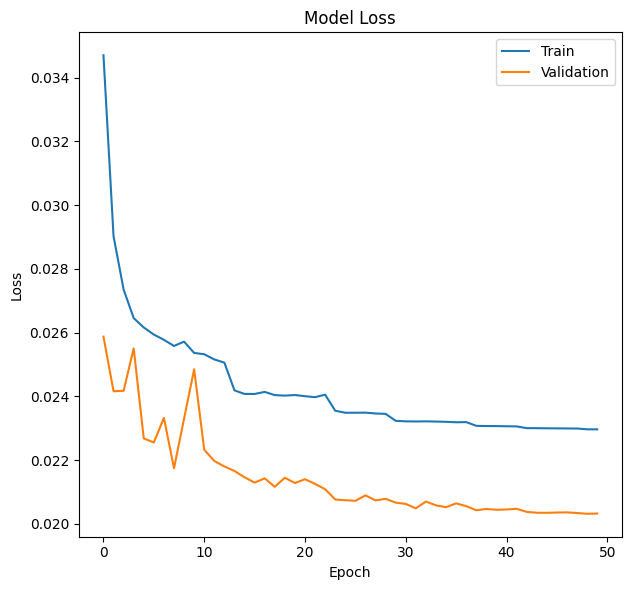

In [ ]:
plot_history(history_cnn30)

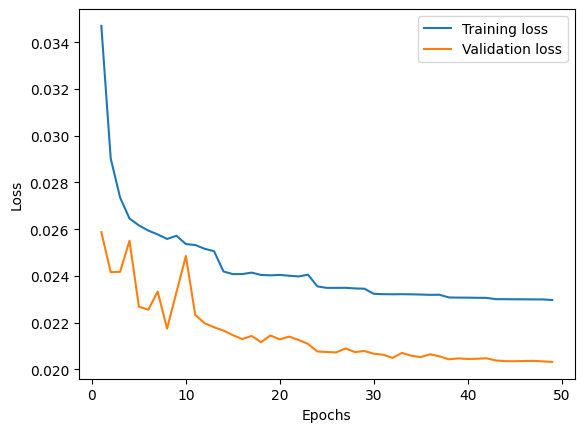

In [ ]:
plot_history_part(history_cnn30, 49)

##TCNN, seq = 30

In [ ]:
def residual_block(inputs):
    shortcut = inputs
    x = layers.Conv1D(filters=32, kernel_size=3, dilation_rate=1, activation='relu', padding='causal')(inputs)
    x = layers.Conv1D(filters=32, kernel_size=3, dilation_rate=2, activation='relu', padding='causal')(x)
    x = layers.Conv1D(filters=32, kernel_size=3, dilation_rate=4, activation='relu', padding='causal')(x)

    if x.shape[-1] != shortcut.shape[-1]:
        shortcut = layers.Conv1D(filters=32, kernel_size=1, padding='same')(shortcut)


    x = layers.add([x, shortcut])

    return x

In [ ]:
def residual_block2(inputs):
    shortcut = inputs
    x = layers.Conv1D(filters=32, kernel_size=3, dilation_rate=1, activation='relu', padding='causal')(inputs)
    x = layers.Conv1D(filters=32, kernel_size=3, dilation_rate=2, activation='relu', padding='causal')(x)
    x = layers.Conv1D(filters=32, kernel_size=3, dilation_rate=4, activation='relu', padding='causal')(x)
    x = layers.Conv1D(filters=32, kernel_size=3, dilation_rate=8, activation='relu', padding='causal')(x)

    if x.shape[-1] != shortcut.shape[-1]:
        shortcut = layers.Conv1D(filters=32, kernel_size=1, padding='same')(shortcut)


    x = layers.add([x, shortcut])

    return x

In [ ]:
inputs = layers.Input(shape=(sequence_length, 1))
x = residual_block(inputs)
x = residual_block2(x)

query = layers.Dense(units=32)(x)
value = layers.Dense(units=32)(x)
attention = layers.Attention()([query, value])

x = layers.Flatten()(attention)

x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(1)(x)

tcnn_30 = keras.models.Model(inputs=inputs, outputs=output)

In [ ]:
tcnn_30.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_squared_error'])

In [ ]:
model_checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/My Drive/tcnn30.keras',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

history_tcnn30 = tcnn_30.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        model_checkpoint_callback,
        reduce_lr
    ]
)

Epoch 1/50
14354/14359 [============================>.] - ETA: 0s - loss: 0.0364 - mean_squared_error: 0.0078
Epoch 1: val_loss improved from inf to 0.02687, saving model to /content/drive/My Drive/tcnn30.keras
14359/14359 [==============================] - 211s 14ms/step - loss: 0.0364 - mean_squared_error: 0.0078 - val_loss: 0.0269 - val_mean_squared_error: 0.0049 - lr: 0.0010
Epoch 2/50
14356/14359 [============================>.] - ETA: 0s - loss: 0.0279 - mean_squared_error: 0.0053
Epoch 2: val_loss improved from 0.02687 to 0.02447, saving model to /content/drive/My Drive/tcnn30.keras
14359/14359 [==============================] - 171s 12ms/step - loss: 0.0279 - mean_squared_error: 0.0053 - val_loss: 0.0245 - val_mean_squared_error: 0.0048 - lr: 0.0010
Epoch 3/50
14355/14359 [============================>.] - ETA: 0s - loss: 0.0263 - mean_squared_error: 0.0052
Epoch 3: val_loss improved from 0.02447 to 0.02275, saving model to /content/drive/My Drive/tcnn30.keras
14359/14359 [====

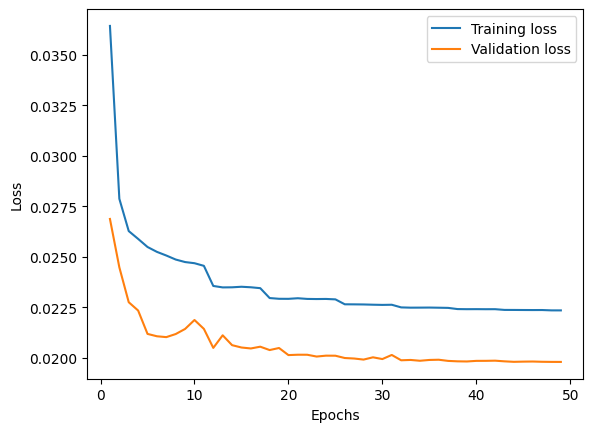

In [ ]:
plot_history_part(history_tcnn30, 49)